## Projectile Ricochet Range and Risk Analysis for Shooting Ranges with Monte Carlo Simulation

This study aims to model the range of ricocheted projectiles in Shooting Ranges and its risk of escaping, as a tool for advising new projects of these buildings in Brazilian Air Force and assure the appropriate risk level for each one. 

The geometric and physical model are described below. The aerodynamic characteristics and post-ricochet behavior are consulted in proper bibliography.

In this study, the projectiles analyzed are the 9 mm and 5.56 mm, which are commonly used in BAF shooting ranges and have enough data available in academic literature.

#### Selecting projectile/shooting characteristics for model

Select bullet caliber: comment with a "#" for the option(s) $\textbf{not}$ desired.

In [1]:
cal = "9mm"
#cal = "5.56mm"

Select shooter position: comment with a "#" for the option(s) $\textbf{not}$ desired

In [2]:
# Shooter position ->
pos = "De pé" #upstanding
#pos = "Deitado" #lying down
#pos = "Joelho" #on knees

#### Importing libraries and defining natural and projectiles constants

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from numpy import vectorize
from scipy.interpolate import UnivariateSpline

import scipy
from statsmodels.distributions.empirical_distribution import ECDF

In [4]:
np.random.seed(1) #for reproducibility of simulations

In [5]:
# natural constants
g = 9.87 #m/s2 gravity acceleration
rho = 1.184 #kg/m3 air density at 1atm and 25°C
pi = np.pi
vsom = 346.3 #m/s sound velocity at 1atm and 25°c

In [6]:
# projectile constants

if cal=="9mm":
    diam = 0.009 #m projectile diameter
    m = 0.0075 #kg projectile mass
    v0 = 410 #m/s projectile initial velocity
    Aref = (1/4)*np.pi*diam**2
    
elif cal=="5.56mm":
    #o nosso é M193
    diam = 0.00556 #m projectile diameter
    m = 0.00356 #kg projectile mass
    v0 = 993 #m/s projectile inital velocity
    Aref = (1/4)*np.pi*diam**2

#### Shooting Range Modeling

In [7]:
# shooter/shooting range constants
# consider that position (0,0) is the ground above the gun

#l = 5  #m distância mínima no chão a partir de onde o atirador erra
L = 50 #m shooting range length
des = 0.2 #vertical gap between shooter ground and sand

if pos=="De pé":
    h = des + 1.7 #m projectile shot height (relative to sand)
elif pos=="Deitado":
    h = des + 0.1 #m projectile shot height (relative to sand)
elif pos=="Joelho":
    h = des + 0.9 #m projectile shot height (relative to sand)

The shooting range is modeled in the cartesian plan where the point (0,0) is the point in the ground below the shooter, in the sand.

There is a ramp in the end the with 40° inclination and 13.44 m of height. There are baffles with 32° inclination and 1.47 length at average height of 2.89 m, shown below.
The number of baffles used and their position are variable, but have influence on the escaping of ricochets. The prior condition of baffle allocation is it can't be possible any direct escaping of projectiles (the sky can't be visible at shot line). There's also a initial baffle wich cover vertical shots up to point (4, 2.9).

All surfaces are considered flat and uniform.

<img src="baffle.png" style="height:400px">

Defining function for baffles/ramp limits (function of their positions) and their plots

In [8]:
def xtolims(x):
    n = len(x)
    lims = []
    lims.append([[x[-1]+0.62, 2.51],[L + 16.02, 13.44]])
    for i in reversed(range(0, n-1)):
        lims.append([[x[i]+0.62, 2.51],[x[i+1]-0.62, 3.29]])
    lims.append([[4,2.9],[x[0]-0.62,3.29]])
    
    return lims


def plot_range(lims):
    fig, ax = plt.subplots(figsize=(20,15))

    ax.plot([0,L], [0,0], color="blue")
    ax.plot([L,L+16.02],[0,13.44], color="blue")

    lens = len(lims)
    ax.plot([0, lims[-1][0][0]],[lims[-1][1][1], lims[-1][0][1]], color="blue")
    ax.plot([0, lims[0][0][0]],[0, lims[0][0][1]], color="red", linewidth=0.5)
    for i in range(lens-1):
        ax.plot([lims[i][0][0], lims[i+1][1][0]], [lims[i][0][1], lims[i+1][1][1]], color="blue")
        ax.plot([0, lims[i+1][0][0]],[0, lims[i+1][0][1]], color="red", linewidth=0.5)
    
    plt.title("Physical model of shooting range")
    
    ax.set_aspect("equal")
    ax.grid()

In [9]:
lims = xtolims([4.8, 7.6, 11.0, 13.9, 43.61])
lims

[[[44.23, 2.51], [66.02, 13.44]],
 [[14.52, 2.51], [42.99, 3.29]],
 [[11.62, 2.51], [13.280000000000001, 3.29]],
 [[8.219999999999999, 2.51], [10.38, 3.29]],
 [[5.42, 2.51], [6.9799999999999995, 3.29]],
 [[4, 2.9], [4.18, 3.29]]]

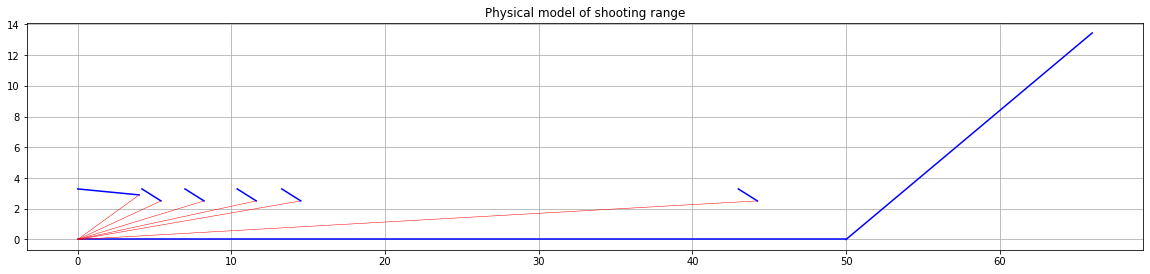

In [10]:
plot_range(lims)

#### Importing Drag Functions for projectiles

The Drag Functions are derived from G1 (for 9mm) and G7 (for 5.56mm) standard projectiles from the Book Applied Ballistics for Long-Range Shooting, 3rd edition, by Bryan Litz.
Both are smoothed by splines.

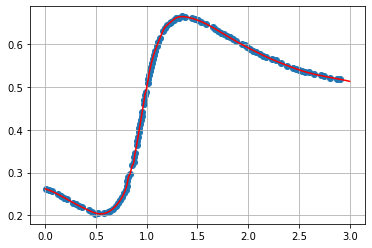

In [11]:
cd9 = pd.read_excel('Cd.xlsx', sheet_name="9mm")

spl9 = UnivariateSpline(cd9['Vel'], cd9['Cd'])
spl9.set_smoothing_factor(0.00005)
xxx = np.linspace(0,3*vsom,1000)


plt.plot(xxx/vsom, spl9(xxx), color="red")
plt.scatter(cd9['Vel']/vsom, cd9['Cd'])
plt.grid()

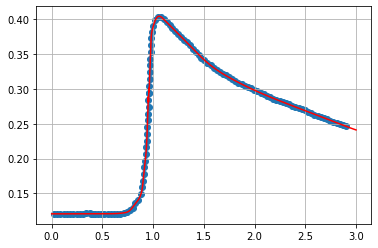

In [12]:
cd556 = pd.read_excel('Cd.xlsx', sheet_name="556mm")

spl556 = UnivariateSpline(cd556['Vel'], cd556['Cd'])
spl556.set_smoothing_factor(0.00005)
xxx = np.linspace(0,3*vsom,1000)

plt.plot(xxx/vsom, spl556(xxx), color="red")
plt.scatter(cd556['Vel']/vsom, cd556['Cd'])
plt.grid()

These G1 and G7 standards must be corrected by the form factor of the models used by BAF. Besides that, the aerodynamic properties must be corrected for post-ricochet behavior. In the lack of post-ricochet data, the study "Surface Danger Zone (SDZ) Methodology Study, Probability Based Surface Danger Zones", by Sami Hoxha and Ernesto Vazquez (US Armament Research, Development and Engineerging Center, 1995) considers the post-ricochet form factor as 2 for its projectiles, considering this value as conservative, once the post-ricochet projectile is deformed and loses its stability. This is the value that will be used in the present study.

In [13]:
if cal=="9mm":
    def Cd(x):
        return 2*spl9(x)
elif cal=="5.56mm":
    def Cd(x):
        return 2*spl556(x)

In [14]:
def k(v):
    return (1/2)*Cd(v)*Aref*rho

## ODE

Here will be implemented the movement equations for the projectile. Are considered the gravitational and drag forces.

In [15]:
from scipy.integrate import ode

Escrita das equações de movimento no espaço de estados:

$$e_0 = x \Rightarrow e_0' = x' = e_2\\
e_1 = y \Rightarrow e_1'=y'=e_3\\
e_2 = x' \Rightarrow e_2' = x'' = -\frac{k}{m}\cdot \sqrt{x'^2+y'^2}\cdot x' = -\frac{k}{m}\cdot \sqrt{e_2^2+e_3^2}\cdot e_2\\
e_3 = y' \Rightarrow e_3' = y'' = -g -\frac{k}{m}\cdot \sqrt{x'^2+y'^2}\cdot y' = -g-\frac{k}{m}\cdot \sqrt{e_2^2+e_3^2}\cdot e_3$$

In [16]:
def mov(t, e):
    vtot = np.sqrt(e[2]**2+e[3]**2)
    return [e[2], e[3], -(k(vtot)/m)*vtot*e[2], -g -(k(vtot)/m)*vtot*e[3] ]

r = ode(mov).set_integrator('vode', method='bdf')

In [17]:
def alcance(x0, y0, ang, vs):
    alpha = ang*pi/180
    r.set_initial_value([x0, y0, vs*np.cos(alpha), vs*np.sin(alpha)],0)


    ttotal = 40
    dt = 5*10**(-4)

    t = []; alt = np.inf
    xtraj = []; ytraj = []
    vxtraj = []; vytraj = []
    while r.successful and r.t<ttotal and alt>=0:
        t.append(r.t)
        rnow = r.integrate(r.t+dt)
        alt = rnow[1]
        alc = rnow[0]
    
    return alc

### Defining the distributions of ricochet angles and ricochet output velocity as a funtion

Here we intend to determine a distribution of ricochet angles (output angle) and ricochet velocities (output velocities) as a function/distribution of projectile velocity before impact and the incidence angle. However, the behavior of these variable are very erratic.

In order to create a realistic model, we model here a multivariate (joint) distribution on angle of incidence, percentage of velocity maintained and angle of ricochet. It was chosen the Gaussian Kernel, which is more usual.

The data for the 9mm was obtained from "Surface Danger Zone (SDZ) Methodology Study, Probability Based Surface Danger Zones", by Sami Hoxha and Ernesto Vazquez (US Armament Research, Development and Engineerging Center, 1995) and the data for the 5.56mm, from "Hazard and Risk Modelling for Weapon Danger Areas" by Tom Adamson, joe Clark and Sam Ellis (Defence Ordnance Safety Group, MOD UK, 2015).

For the 9mm projectile, the bandwidth selection was automatically made with the "rule-of-thumb", but for 5.56mm, the badwidth selected is 0.175, which gave a more adjusted result for small angles of incidece, which will be more useful further.

In [18]:
from scipy import stats

In [19]:
%%time
if cal=="5.56mm":
    data556 = pd.read_excel("556infoc.xlsx")
    
    neglim = 3
    
    xmin = -neglim; xmax = 25
    ymin = 0; ymax = 1
    zmin = 0; zmax = 45
    
    precfactor = 5
    size = precfactor*(xmax-xmin)+1
    
    
    values = np.vstack([data556['Ainc'], data556['Vratio'], data556['Elev']])
    kernel = stats.gaussian_kde(values)
    kernel.set_bandwidth(bw_method=.15)

    X, Y, Z = np.mgrid[xmin:xmax:(size*1j), ymin:ymax:(size*1j), zmin:zmax:(size*1j)]
    positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

    W = np.reshape(kernel.evaluate(positions).T, X.shape)
    
    YY, ZZ = np.mgrid[ymin:ymax:(size*1j), zmin:zmax:(size*1j)]
    pospos = np.vstack([YY.ravel(), ZZ.ravel()])
    
    cor = (X.shape[0]-1)/xmax #considering X, Y and Z have the same shape
    
    
    listpoints556 = list(range(pospos[0].shape[0]))
    
    
    def gen(angincid):
        index = int(precfactor*(angincid + neglim))
        probs556 = W[index].reshape(size**2)/(W[index].reshape(size**2).sum())
        
        posicoessort = np.random.choice(listpoints556, 1, p=probs556)
        posaux = pospos[:,posicoessort] #retorna Vr/Vi e Asaida
        return [posaux[0][0]*(v0 - 1.07*h/np.tan(angincid*pi/180)), posaux[1][0]] #transforma razao de velocidade em velocidade
    
    
if cal == "9mm": 
    ric = pd.read_csv('ric9mmsand.csv', sep=";")
    ric_v = ric.dropna()
       
    xmin = 0; xmax = 25 #incidencia
    ymin = 0; ymax = 1 #vrvi
    zmin = 0; zmax = 45 #saida

    values = np.vstack([ric_v['impact angle'], ric_v['Vr/Vi'], ric_v['Elev/R']])
    kernel = stats.gaussian_kde(values)
    

    Nsize = 101 

    X, Y, Z = np.mgrid[ xmin:xmax:(Nsize*1j), ymin:ymax:(Nsize*1j), zmin:zmax:(Nsize*1j)]
    positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

    W = np.reshape(kernel.evaluate(positions).T, X.shape)
    
    YY, ZZ = np.mgrid[ymin:ymax:(Nsize*1j), zmin:zmax:(Nsize*1j)]
    pospos = np.vstack([YY.ravel(), ZZ.ravel()])
    
    cor = (Nsize-1)/xmax
    listpoints9 = list(range(pospos[0].shape[0]))
    
    def gen(angincid):
        index = int(cor*angincid)
        probs9 = W[index].reshape(Nsize**2)/(W[index].reshape(Nsize**2).sum())
        
        posicoessort = np.random.choice(listpoints9, 1, p=probs9)
        posaux = pospos[:,posicoessort] #retorna Vr/Vi e Asaida
        return [posaux[0][0]*(v0 - 1.07*h/np.tan(angincid*pi/180)), posaux[1][0]] #transforma razao de velocidade em velocidade

Wall time: 9.71 s


### Defining baffles and ramp interferences

The function below compares the escape of a ricocheted bullet with a determined point, which could be a point in a baffle

In [20]:
def F(x, alp, xp, yp, vr): 
    ''' dado o ponto do para-balas/talude, a trajetoria passa sobre ou sob esse ponto?
        a trajetoria parte do ponto x com alp graus
        se resultado é positivo, passa por cima do ponto
        se negativo, abaixo
    '''
    return -yp + (xp-x)*np.tan(alp*pi/180) - (1/2)*g*(xp-x)**2/(vr**2*(np.cos(alp*pi/180))**2)

In [21]:
def beta(x):
    return np.arctan(h/x)*180/pi

In [22]:
def fuga(x, alp, lims=lims):
    '''
    Inputs: Ground point of shot, possible ricochet angle
    Outputs: 0/1 if ricochet is contained or not, ricochet angle and stochastical residual velocity
    '''
    ainc = beta(x)
    aux = gen(ainc)
    vr = aux[0]
    
    for pos in lims:
        if (F(x, alp, pos[0][0], pos[0][1], vr) <= 0) and (F(x, alp, pos[1][0], pos[1][1], vr) >= 0):
            return 1, alp, vr
    return 0, alp, vr

### Monte Carlo Simulation

Here we finally create the "experiment" and estimate the probabilities of ricochet escaping and range of these projectiles.

In [23]:
# library for parallelizing calculations
from joblib import Parallel, delayed

In [24]:
# Sample size of simulation for each projectile for viable execution times
if cal=="9mm":
    N = 500000
if cal=="5.56mm":
    N = 100000
np.random.seed(2)

Here we model the shooter angular error. This was calculated over the register of shooting training in BAF. It were considered a normal distribution, with mean 0, with ~80% of hits on the target, as registered. The lateral errors were considered vertical, making this model more conservative. Then, we calculate the probability of shooting the ground.

In [25]:
# angular error of shooter - may be different between 9mm and 556mm
# consider N(0, sigma = sig_shooter), in degrees
if cal=="9mm":
    sig_shooter = 1.63
if cal=="5.56mm":
    sig_shooter = 0.95
    
prob_ground_shot = stats.norm.cdf(-np.tan(h/L)*180/pi, 0, sig_shooter)
prob_ground_shot

0.09071367186380586

Once we have the probability of shooting the ground, we generate the error angles with a truncated normal, for which all of the shots hit the ground.

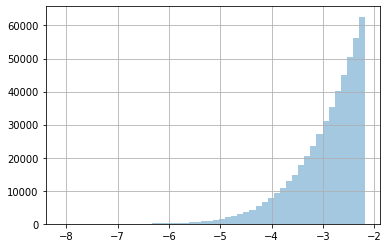

In [26]:
#generate only shots in the ground for simulation efficiency (truncated normal)
np.random.seed(3)
genangles = sig_shooter*stats.truncnorm.rvs(-25/sig_shooter, -(np.tan(h/L)*180/pi)/sig_shooter, size=N)
sns.distplot(genangles, kde=False)
plt.grid()

Then we transform these error angles in the distance they reach in ground, which is a parameter for our functions.

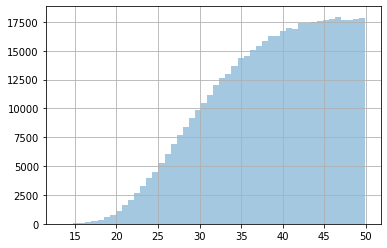

In [27]:
dsim = h/np.tan(-genangles*pi/180)
sns.distplot(dsim, kde=False)
plt.grid()

For each point on ground, this function generates an output velocity ang output (ricochet) angle, according to the multivariate distributions defined sooner.

It returns 1 if the ricochet escapes the shooting range and 0 if it's contained by the baffles or the ramp.

In [28]:
def fugasim(x, lims=lims):
    '''
    Inputs: Ground point of shot, possible ricochet angle
    Outputs: 0/1 if ricochet is contained or not, ricochet angle and stochastical residual velocity
    '''
    ainc = beta(x)
    aux = gen(ainc)
    vr = aux[0]
    alp = aux[1]
    
    for pos in lims:
        if (F(x, alp, pos[0][0], pos[0][1], vr) <= 0) and (F(x, alp, pos[1][0], pos[1][1], vr) >= 0):
            return 1, alp, vr
    return 0, alp, vr

For each point on groud, we record the conditions for which the projectiles escape the shooting range

In [29]:
from tqdm import tqdm

In [30]:
%%time
np.random.seed(1)
fugas = []; condfuga = []
for d in tqdm(dsim, position=0):
    auxfuga = fugasim(d)
    #fugas.append(auxfuga[0])
    if auxfuga[0]:
        condfuga.append([d, 0, auxfuga[1], auxfuga[2]])

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [06:08<00:00, 1357.09it/s]


Wall time: 6min 8s


In [31]:
kescape = len(condfuga)

Let's see the 95% confidence interval considering as the Bayesian prior probability an uniform distribution from 0 to 1.

In [32]:
stats.beta.interval(0.95, a = kescape+1, b=N-kescape+1)

(0.006713706819151108, 0.007173973565660741)

In [33]:
print('The probability of ground ricocheted {:s} projectile escaping the shooting range is {:.5g} '.format(cal, kescape/N))

The probability of ground ricocheted 9mm projectile escaping the shooting range is 0.00694 


Now, let's calculate the range of the escaping projectiles

In [34]:
%%time
alcances = Parallel(n_jobs=-1, max_nbytes = None)(delayed(alcance)(*cond) for cond in tqdm(condfuga, position=0))

100%|██████████████████████████████████████████████████████████████████████████████| 3470/3470 [01:21<00:00, 42.71it/s]


Wall time: 1min 21s


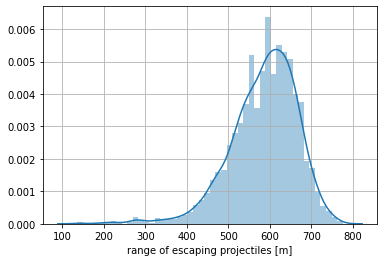

In [35]:
ax = sns.distplot(alcances)
ax.set(xlabel = 'range of escaping projectiles [m]')
plt.grid()

[Text(0.5, 0, 'impact d [m]'), Text(0.5, 1.0, 'Impact point distribution')]

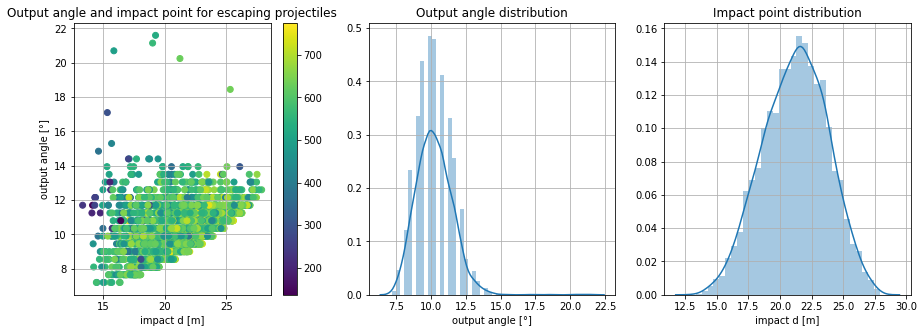

In [36]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

angssaida = [item[2] for item in condfuga]
dsaida = [item[0] for item in condfuga]

im = ax[0].scatter(dsaida, angssaida, c=alcances)
fig.colorbar(im, ax=ax[0])
ax[0].grid()
ax[0].set(xlabel='impact d [m]', ylabel='output angle [°]', title='Output angle and impact point for escaping projectiles')

sns.distplot(angssaida, ax=ax[1])
ax[1].grid()
ax[1].set(xlabel='output angle [°]', title='Output angle distribution')

sns.distplot(dsaida, ax=ax[2])
ax[2].grid()
ax[2].set(xlabel='impact d [m]', title='Impact point distribution')

In [37]:
cdf_alcances = scipy.stats.norm.cdf(alcances)
ecdf = ECDF(alcances)

Cumulative Distribution of range of escaping projectiles:

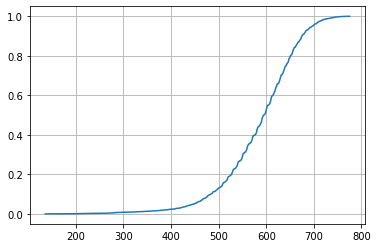

In [38]:
sns.lineplot(ecdf.x, ecdf.y)
plt.grid()

In [39]:
#checar condição de parcialmente coberto
if cal=="9mm":
    print('Escape probability: {:g}'.format( prob_ground_shot*kescape/N))
    print('Probability of escaping bullet with range greater than 900m: {:g}'.format(prob_ground_shot*(kescape/N)*(1-ecdf(900))))
if cal=="5.56mm":
    print('Escape probability: {:g}'.format( prob_ground_shot*(kescape/N)))
    print('Probability of escaping bullet with range greater than 1800m {:g}'.format(prob_ground_shot*(kescape/N)*(1-ecdf(1800))))

Escape probability: 0.000629553
Probability of escaping bullet with range greater than 900m: 0
